#Technical Indicators Framework
A collection of methods to compute various technical indicators from equity closing prices.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import math

In [9]:
start = '2016-06-01'
end = '2017-06-01'
data = get_pricing(['AAPL'], fields='close_price', start_date=start, end_date=end)
data.columns = [e.symbol for e in data.columns]

In [12]:
asset = data['AAPL']
rsi = calc_RSI(asset)
bollinger = calc_bollinger(asset, 20, 2)
stoch = calc_stoch(asset, 14)

##Bollinger bands

The following formula is used to calculate the bands:

$$\text{upper band} = \text{SMA} + 2\sigma$$
$$\text{lower band} = \text{SMA} - 2\sigma$$

Where the simple moving average and standard deviation are calculated over $N$ days. 

The $\text{bandwidth}$ and $\text{%}b$ are also calculated according to the following formulas:

$$\text{%}b = \frac{\text{price} - \text{lower band}}{\text{upper band} - \text{lower band}}$$

$$\text{bandwidth} = \frac{\text{upper band} - \text{lower band}}{\text{SMA}}$$

In [4]:
def calc_bollinger(asset, N, K):
    column_list = ['close', 'std', 'sma', 'upper_band', 'lower_band', '%b', 'bandwith']
    bollinger = pd.DataFrame(columns=column_list, index=asset.index)
    bollinger['close'] = asset
    bollinger['std'] = bollinger['close'].rolling(window=N).std()
    bollinger['sma'] = bollinger['close'].rolling(window=N).mean()
    bollinger['upper_band'] = bollinger['sma'] + bollinger['std'] * K
    bollinger['lower_band'] = bollinger['sma'] - bollinger['std'] * K
    bollinger['%b'] = 100 * (bollinger['close'] - bollinger['lower_band']) / (bollinger['upper_band'] - bollinger['lower_band']) 
    bollinger['bandwith'] = 100 * (bollinger['upper_band'] - bollinger['lower_band']) / bollinger['sma']
    return bollinger.dropna()

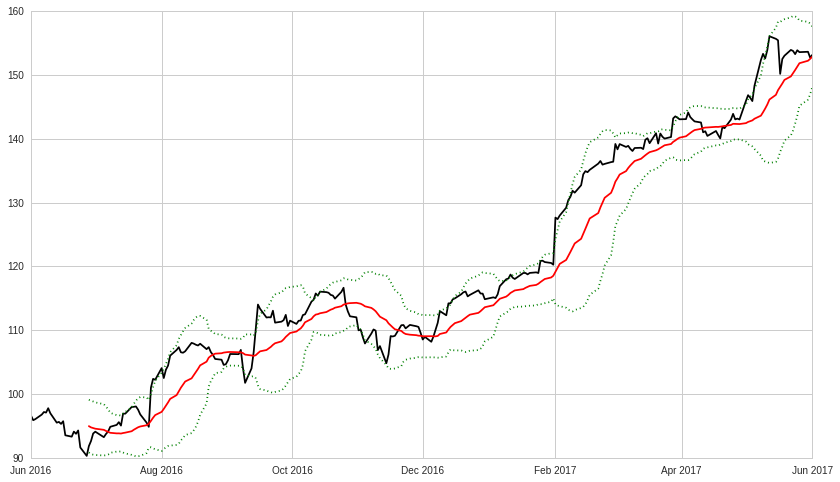

In [11]:
plt.plot(asset, color='black')
plt.plot(bollinger['lower_band'], color='green', linestyle=':')
plt.plot(bollinger['upper_band'], color='green', linestyle=':')
plt.plot(bollinger['sma'], color='red')

###%b and bandwith

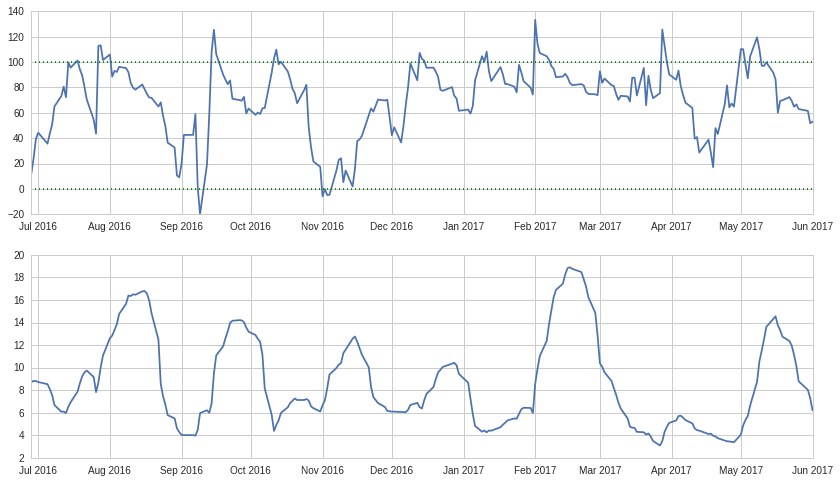

In [21]:
fig = plt.figure()

ax1 = plt.subplot(211)
ax2 = plt.subplot(212)

ax1.plot(bollinger['%b'])
ax1.axhline(color='g', linestyle=':', y=100)
ax1.axhline(color='g', linestyle=':', y=0)

ax2.plot(bollinger['bandwith'])

plt.show()

##Relative Strength Index
The following method calculates the RSI with the following algorithm.

Each trading day is characterized by either positive or negative change and an upward or downward change is recorded.

For an upward change:
$$U = \text{close}_{\text{now}} - \text{close}_{\text{previous}}$$
$$D=0$$

For a downward change:
$$U = 0$$
$$D=\text{close}_{\text{previous}} - \text{close}_{\text{now}}$$

The relative strength is calculated using the ratio of the exponential averages of upwards and downwards changes.

$$\text{RS}=\frac{\text{EMA}(U, n)}{\text{EMA}(D, n)}$$

A normalized scale from 0 to 100 is then used for the RSI calculated below.

$$\text{RSI} = 100 - \frac{100}{1+\text{RS}}$$

In [2]:
def calc_RSI(asset):
    window_length = 27
    column_list = ['close', 'up', 'down', 'up_ema', 'down_ema' 'ratio', 'score']
    rsi = pd.DataFrame(columns=column_list, index=asset.index)
    prev_close = np.nan
    for index, row in rsi.iterrows():
        row['close'] = asset.loc[index]
        curr_close = row['close']
        if curr_close > prev_close:
            row['up'] = curr_close - prev_close
            row['down'] = 0
        elif curr_close < prev_close:
            row['up'] = 0
            row['down'] = prev_close - curr_close
        prev_close = row['close']

    up_ema = rsi['up'].ewm(span=window_length, adjust=False, min_periods=window_length).mean()
    down_ema = rsi['down'].ewm(span=window_length, adjust=False, min_periods=window_length).mean()

    rsi = pd.Series(index=asset.index)
    for date in rsi.index:
        ratio = up_ema.loc[date] / down_ema.loc[date]
        score = 100 - 100 / (1 + ratio)
        rsi.loc[date] = score
    return rsi

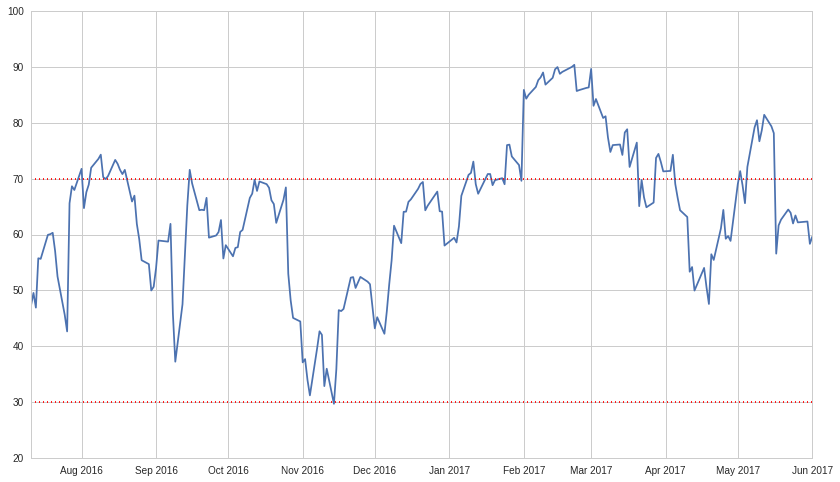

In [26]:
plt.plot(rsi)
plt.axhline(color='r', linestyle=':', y=70)
plt.axhline(color='r', linestyle=':', y=30)

##Stochastic oscillator

The following formula is used:
$$\text{%}K = 100 \times \frac{\text{closing price} - L}{H - L}$$

where $H$ and $L$ represent the highest and lowest prices over $N$ periods.

A simple moving average of the indicator is also defined as followed, given by $\text{%}D$

$$\text{%}D = \text{3 period moving average of %}K$$ 

In [3]:
def calc_stoch(asset, N):
    window_length = N
    stoch = pd.DataFrame(index=asset.index)
    stoch['close'] = asset
    stoch['%K'] = 100 * (stoch['close'] - stoch['close'].rolling(window=window_length).min()) / (stoch['close'].rolling(window=window_length).max() - stoch['close'].rolling(window=window_length).min())
    stoch['%D'] = stoch['%K'].rolling(window=3).mean()
    return stoch

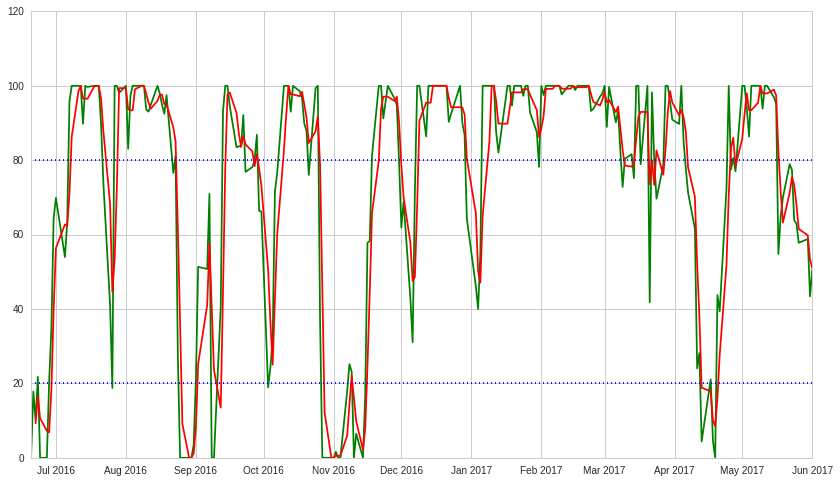

In [27]:
plt.plot(stoch['%K'], color='g')
plt.plot(stoch['%D'], color='r')
plt.axhline(color='b', linestyle=':', y=80)
plt.axhline(color='b', linestyle=':', y=20)